# Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy.stats import binom
from pathlib import Path
from zlib import crc32
import urllib.request
import pandas as pd
import numpy as np
import tarfile

# Get Data

In [2]:
def load_housing_data() -> pd.DataFrame:
    tarball_path = Path("../data/housing.tgz")
    if not tarball_path.is_file():
        Path("../data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="../data")
            
    return pd.read_csv("../data/housing/housing.csv")

# Path Images

In [3]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Load Data

In [4]:
housing = load_housing_data()

# Take a Quick Look at the Data Structure

In [5]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


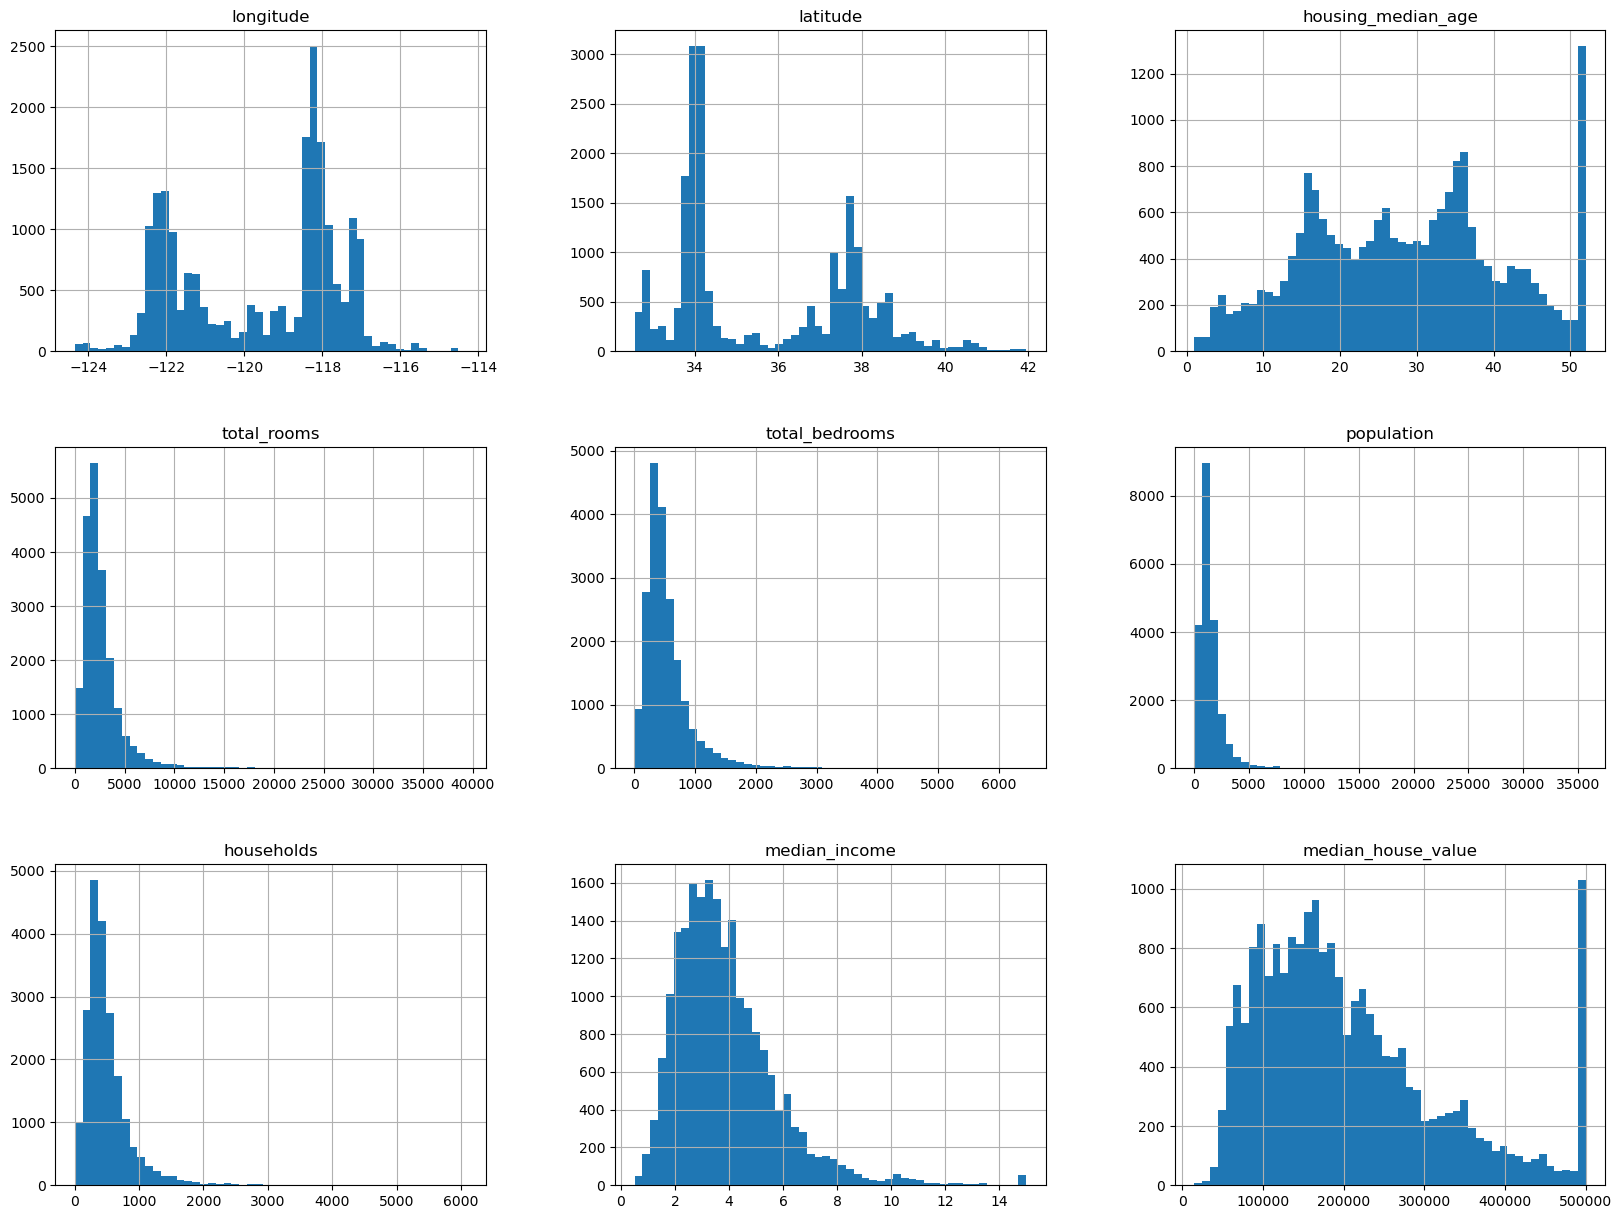

In [9]:
housing.hist(bins = 50, figsize=(20,15))
plt.show()

# Create a Test Set

In [10]:
def shuffle_and_split_data(data : pd.DataFrame, seed: int, test_ratio : float) -> (pd.DataFrame, pd.DataFrame):
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

This is a manual way of splitting the test data. However, when updated the test set data will change.

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 42, 0.2)

To avoid this, the dataset's own IDs can be used as identifiers for each instance, assuming that they are unique and immutable. However, if this does not exist, it is recommended to calculate a hash to create an identifier for each instance and place the test set if the hash is less than or equal to 20% of the maximum value of the hash. This ensures that the test set is constant each time it is updated and that new instances in the collection have not been in the input data before.

In [12]:
def is_id_in_test_set(identifier: int, test_ratio: float) -> bool:
    return crc32(np.int64(identifier)) < test_ratio * 2**32 

def split_data_with_id_hash(data : pd.DataFrame, test_ratio : float, id_column : str) -> (pd.DataFrame, pd.DataFrame):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [15]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

To find the probability that a random sample of 1,000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.1%, we use the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [16]:
# extra code – shows how to compute the 10.7% proba of getting a bad sample

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


If you prefer simulations over maths, here's how you could get roughly the same result:

In [17]:
# extra code – shows another way to estimate the probability of bad sample

np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)
((samples < 485) | (samples > 535)).mean()

0.1071

We use `np.cut()` to create a categorical attribute based on the variable `median_income'.

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

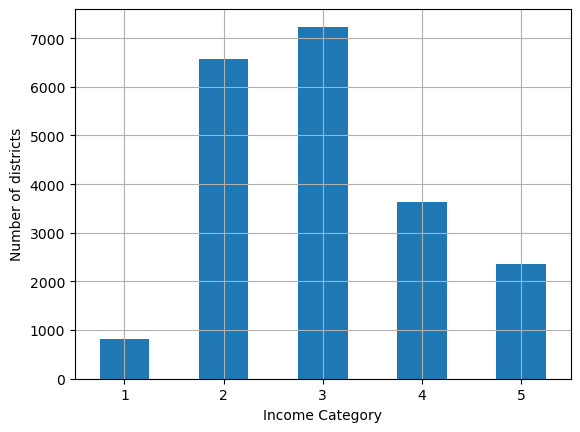

In [19]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [21]:
strat_train_set, strat_test_set = strat_splits[0]

In [22]:
strat_train_set, strat_test_set = train_test_split(housing, test_size = 0.2, stratify = housing["income_cat"], random_state = 42)

In [23]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [24]:
# extra code – computes the data for Figure 2–10

def income_cat_proportions(data : pd.DataFrame) -> pd.Series:
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()

compare_props.index.name = "Income Category"

compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)

compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

# Discover and Visualize the Data to Gain Insights

In [26]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

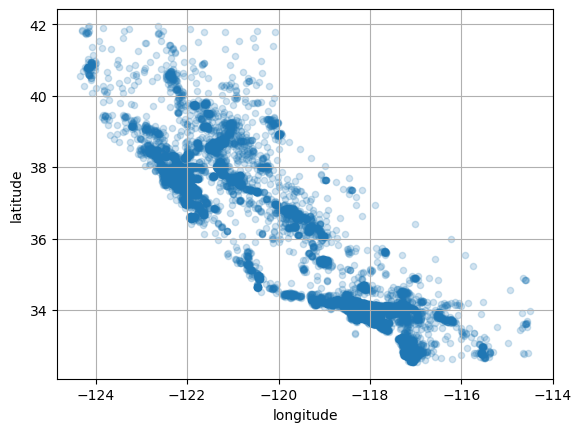

In [27]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True, alpha = 0.2)
plt.show()

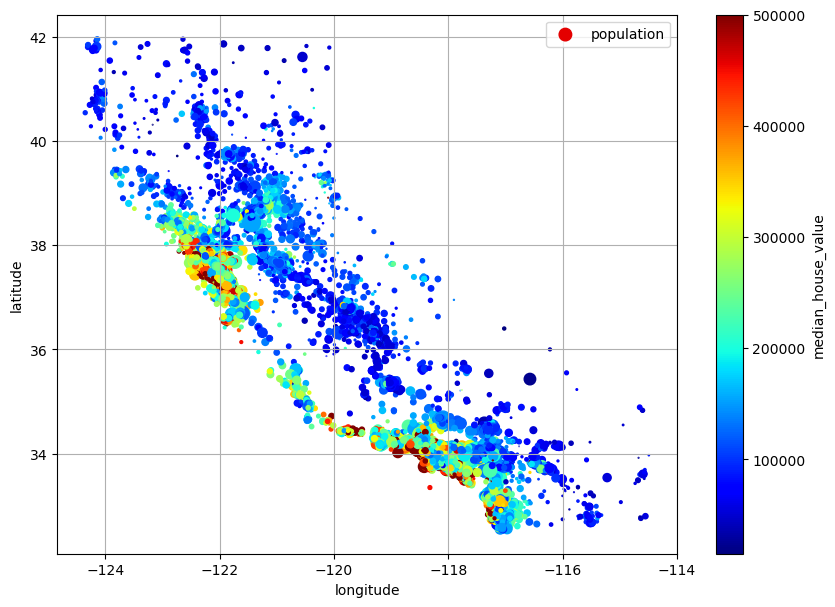

In [28]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", grid = True,
             s = housing["population"] / 100, label = "population",
             c = "median_house_value", cmap = "jet", colorbar = True,
             legend = True, sharex = False, figsize = (10, 7))
plt.show()

The argument `sharex=False` fixes a display bug: without it, the x-axis values and label are not displayed (see: https://github.com/pandas-dev/pandas/issues/10611).

The next cell generates the first figure in the chapter (this code is not in the book). It's just a beautified version of the previous figure, with an image of California added in the background, nicer label names and no grid.

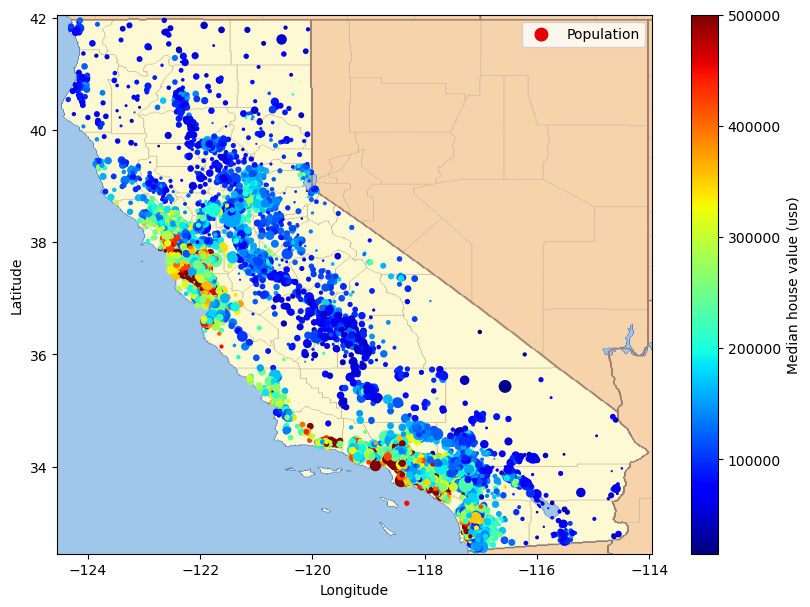

In [29]:
# extra code – this cell generates the first figure in the chapter

# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

## Looking for Correlations

In [30]:
corr_matrix = housing.corr(numeric_only = True)

In [31]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

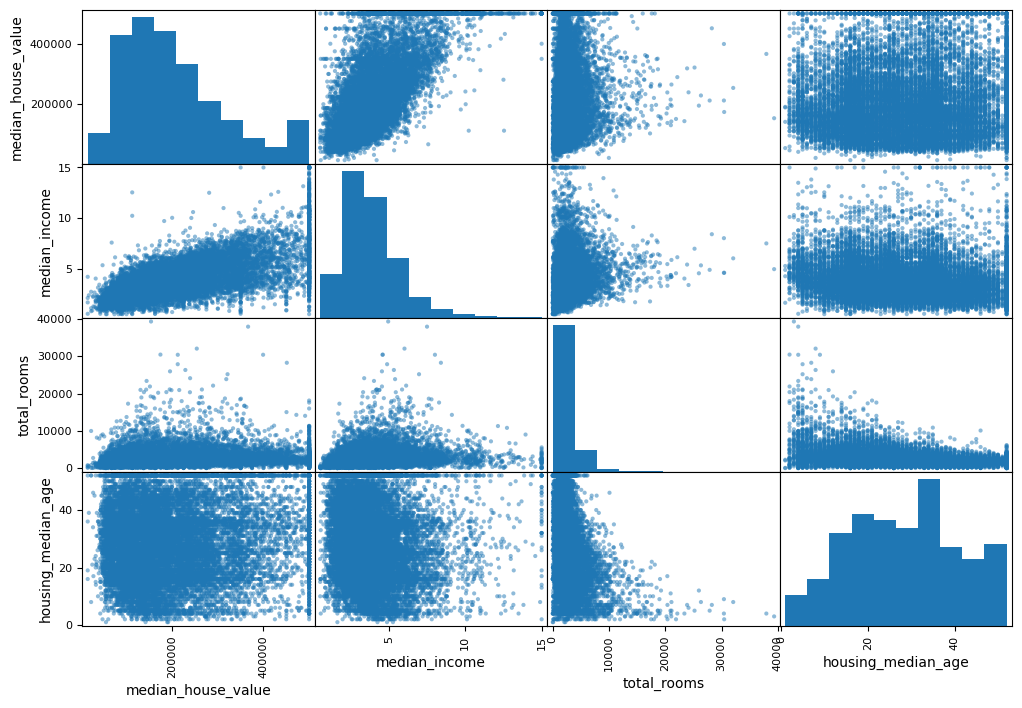

In [32]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

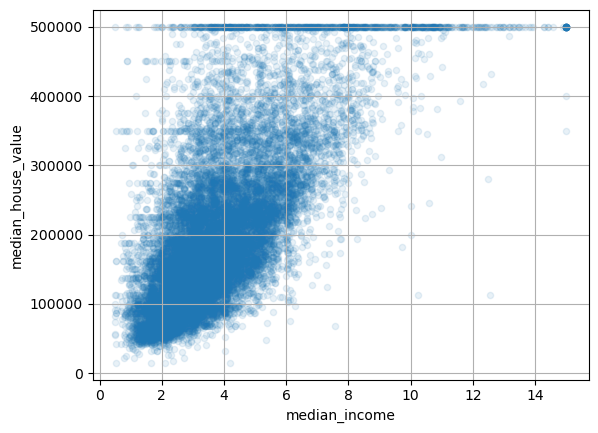

In [33]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1, grid = True)
plt.show()

# Experiment with Attribute Combinations

In [34]:
housing["room_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [35]:
corr_matrix = housing.corr(numeric_only= True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
room_per_house        0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms


In [36]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_objects = strat_train_set["median_house_value"].copy()

In [37]:
housing.dropna(subset = ["total_bedrooms"]) # option 1

housing.drop("total_bedrooms", axis = 1) # option 2

median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median)

13096    1115.0
14973     354.0
3785      217.0
14689     851.0
20507    1211.0
          ...  
14207     597.0
13105     592.0
19301     775.0
19121     873.0
19888     195.0
Name: total_bedrooms, Length: 16512, dtype: float64

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [38]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [39]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [41]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3

housing_option3.loc[null_rows_idx].head(5)

C:\Users\HP\AppData\Local\Temp\ipykernel_19076\871818244.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [43]:
housing_num = housing.select_dtypes(include = [np.number])

In [44]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [45]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [46]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this `“trained”` imputer to transform the training set by replacing missing values with the learned medians:

In [47]:
X = imputer.transform(housing_num)

In [48]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)

In [49]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


Now let's drop some outliers:

In [50]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [51]:
outlier_pred

array([-1,  1,  1, ...,  1,  1,  1])

## Handling Text and Categorical Attributes

**Now** let's preprocess the categorical input feature, `ocean_proximity`:

In [52]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [53]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [54]:
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [55]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [57]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [58]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [59]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Alternatively, you can set `sparse_output=False` when creating the `OneHotEncoder` (note: the `sparse` hyperparameter was renamned to `sparse_output` in Scikit-Learn 1.2):

In [60]:
cat_encoder = OneHotEncoder(sparse_output = False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot 

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [61]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [62]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [63]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [64]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [65]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [66]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [67]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [68]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                        columns = cat_encoder.get_feature_names_out(),
                        index = df_test_unknown.index)

In [69]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


## Feature Scaling

In [70]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range =(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [71]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
housing_num_standard_scaled = standard_scaler.fit_transform(housing_num)

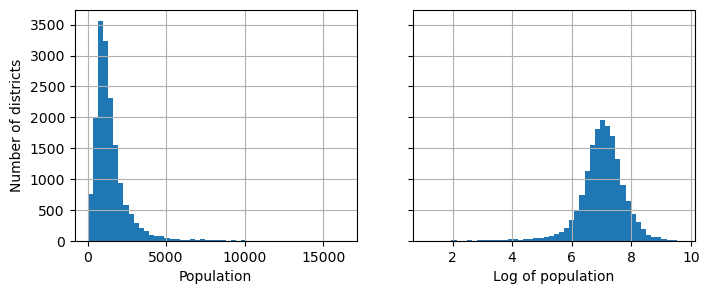

In [72]:
fig, axs = plt.subplots(1, 2, figsize = (8, 3), sharey = True)
housing["population"].hist(ax = axs[0], bins = 50)
housing["population"].apply(np.log).hist(ax = axs[1], bins = 50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

What if we replace each value with its percentile?

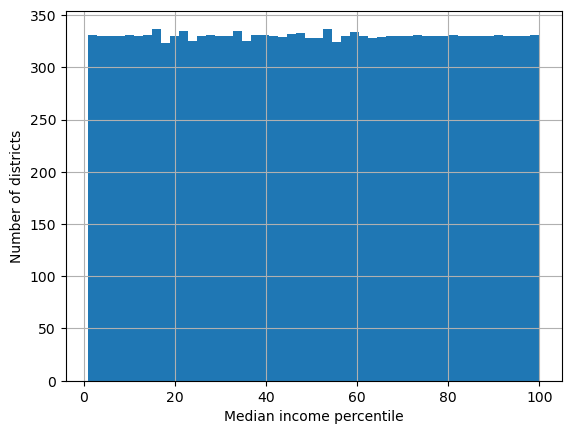

In [73]:
# extra code – just shows that we get a uniform distribution
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100)

In [74]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma = 0.1)

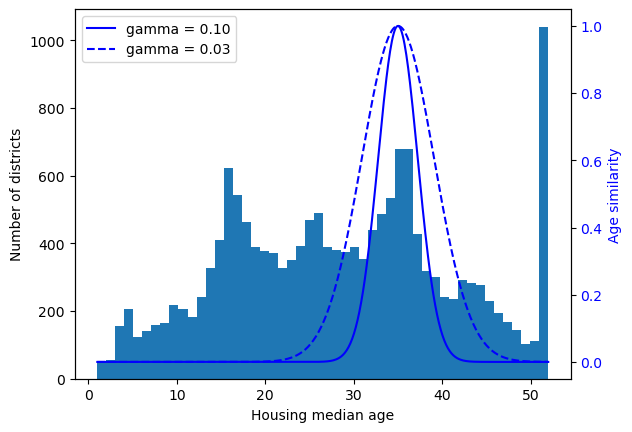

In [75]:
#extra code -this cell generates Figure 2-18

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500
).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma = gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma = gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins = 50)

ax2 = ax1.twinx()
color = "blue"
ax2.plot(ages, rbf1, color = color, label = "gamma = 0.10")
ax2.plot(ages, rbf2, color = color, label = "gamma = 0.03", linestyle = "--")
ax2.tick_params(axis = "y", labelcolor = color)
ax2.set_ylabel("Age similarity", color = color)

plt.legend(loc = "upper left")
plt.show()

In [76]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_objects.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [77]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [78]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer = StandardScaler())

model.fit(housing[["median_income"]], housing_objects)
predictions = model.predict(some_new_data) 
# Note: As the model has used a scaling, when making predictions 
# it will perform an inverse transformation to the scaling to 
# obtain the original result.

In [79]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

In [80]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func = np.exp)
log_pop = log_transformer.transform(housing[["population"]])
log_inverse = log_transformer.inverse_transform(log_pop)

In [81]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args = dict(Y = [[35.]], gamma = 0.1))

age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [82]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [83]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args = dict(Y = [sf_coords], gamma = 0.1))

sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [84]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1, 2], [3, 4]]))

array([[0.5 ],
       [0.75]])

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True): # no *args or **kwargs
        self.with_mean = with_mean

    def fit(self, X : pd.DataFrame, y = None):
        X = check_array(X) # checks that X is an array with finite float values
        self.mean_ = X.mean(axis = 0)
        self.scale_ = X.std(axis = 0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always return self
    
    def transform(self, X : pd.DataFrame):
        check_is_fitted(self) # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X -= self.mean_
        return X / self.scale_

In [86]:
standard_scaler_clone = StandardScalerClone()

housing_num_scaled = standard_scaler_clone.fit_transform(housing_num[["median_income", "population"]])

In [87]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X : pd.DataFrame, y = None, sample_weight = None):
        self.kmeans_ = KMeans(self.n_clusters, random_state = self.random_state)
        self.kmeans_.fit(X, sample_weight = sample_weight) 
        # `sample_weight` allows the user to specify the relative weights of the samples.
        return self

    def transform(self, X : pd.DataFrame):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [88]:
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1, random_state = 42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight = housing_objects)

This code creates a ClusterSimilarity transformer, setting the number of clusters to 10. Then it calls `fit_transform()` with the latitude and longitude of every district in the training set, weighting each district by its median house value. The transformer uses k-means to locate the clusters, then measures the **Gaussian RBF** similarity between each district and all 10 cluster centers. The result is a matrix with one row per district, and one column per cluster. Let’s look at the first three rows, rounding to two decimal places:

In [89]:
similarities[:3].round(2)

array([[0.  , 0.98, 0.  , 0.  , 0.  , 0.  , 0.13, 0.55, 0.  , 0.56],
       [0.64, 0.  , 0.11, 0.04, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.65, 0.  , 0.  , 0.01, 0.  , 0.49, 0.59, 0.  , 0.28]])

In [90]:
cluster_simil.get_feature_names_out()

['Cluster 0 similarity',
 'Cluster 1 similarity',
 'Cluster 2 similarity',
 'Cluster 3 similarity',
 'Cluster 4 similarity',
 'Cluster 5 similarity',
 'Cluster 6 similarity',
 'Cluster 7 similarity',
 'Cluster 8 similarity',
 'Cluster 9 similarity']

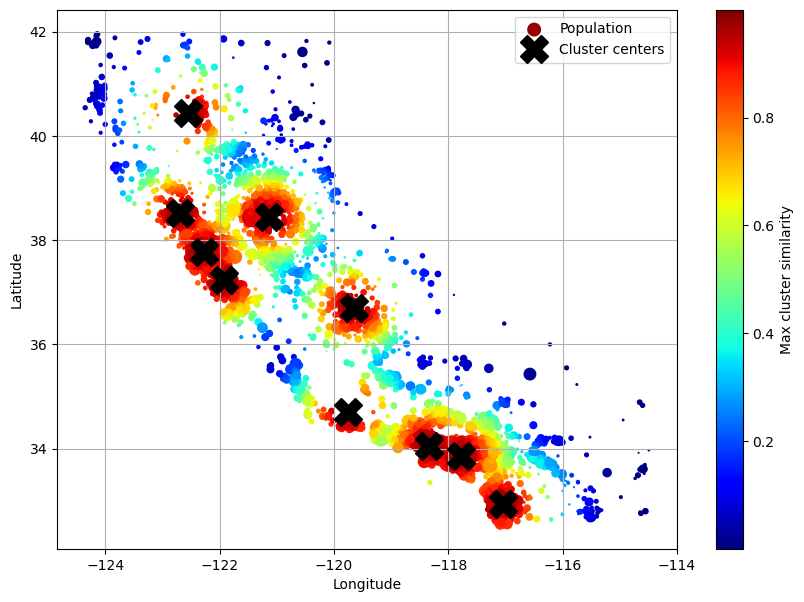

In [91]:
# extra code – this cell generates Figure 2–19
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## Transformation Pipelines

Now let's build a pipeline to preprocess the numerical attributes:

In [92]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("scaler", StandardScaler())
])

In [93]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy = "median"), StandardScaler())

In [94]:
from sklearn import set_config

set_config(display = "diagram")

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [95]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [96]:
num_pipeline[1]

StandardScaler()

In [97]:
num_pipeline[:-1]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median'))])

In [98]:
num_pipeline.named_steps

{'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler()}

In [99]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

In [100]:
num_pipeline.set_params(simpleimputer__strategy = "median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [101]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns = num_pipeline.get_feature_names_out(),
    index = housing_num.index
)

In [102]:
df_housing_num_prepared.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
16763,-1.283076,1.112048,1.702204,-0.402432,-0.466744,-0.625263,-0.480575,0.332776
2550,0.946296,-0.969304,-2.111752,3.372014,2.169459,1.940591,1.669068,3.299246
14936,-0.903183,1.435502,-0.284232,0.585569,0.536056,0.710187,0.739210,-0.861698
19251,1.276203,-0.345836,0.669257,-0.659156,-0.443037,-0.587812,-0.532814,-1.172870
4162,-0.953169,1.374561,0.748715,0.077611,0.633254,-0.166716,0.744434,-1.067314


In [103]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown = "ignore")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [104]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include = np.number)),
    (cat_pipeline, make_column_selector(dtype_include = object))
)

In [105]:
housing_prepared = preprocessing.fit_transform(housing)

In [106]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [107]:
housing_prepared_fr = pd.DataFrame(housing_prepared, 
                                    columns = preprocessing.get_feature_names_out(),
                                    index = housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [108]:
def column_ratio(X):
    return X[:,[0]] / X[:,[1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy = "median"),
        FunctionTransformer(column_ratio, feature_names_out = ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy = "median"),
    FunctionTransformer(np.log, feature_names_out = "one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
    ],
    remainder = default_num_pipeline
)

In [109]:
housing_prepared = preprocessing.fit_transform(housing)

In [110]:
housing_prepared.shape

(16512, 24)

In [111]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [112]:
housed_prepared_fr = pd.DataFrame(housing_prepared,
                                columns = preprocessing.get_feature_names_out(),
                                index = housing.index)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [113]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_objects)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026567C40340>)])),
                ('linearregression', LinearRegression())])

In [114]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2) # -2 = rounded to the nearest hundred

array([246000., 372700., 135700.,  91400., 330900.])

In [115]:
housing_objects.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

In [116]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_objects.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-46.3%, -23.0%, 33.4%, -4.9%, -8.5%


In [117]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_objects, housing_predictions, squared = False)
lin_rmse

c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68972.88910758484

In [118]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 42))
tree_reg.fit(housing, housing_objects)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026567C40340>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [119]:
housing_preditions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_objects, housing_preditions, squared = False)

c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [120]:
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [121]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_objects, 
                             scoring = "neg_root_mean_squared_error", cv = 10)

In [122]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.360949
std       1460.198570
min      64289.376198
25%      66776.146282
50%      67086.216281
75%      68140.275029
max      68659.294290
dtype: float64

In [123]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_objects,
                                scoring="neg_root_mean_squared_error", cv=10)

In [124]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47124.604437
std       1069.311372
min      45292.329302
25%      46712.106520
50%      47172.209883
75%      47561.377695
max      49354.705514
dtype: float64

In [125]:
forest_reg.fit(housing, housing_objects)

housing_predict = forest_reg.predict(housing)

forest_rmse = mean_squared_error(housing_objects, housing_predict, squared = False)
forest_rmse

c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


17519.685029292894

# Fine-Tune Your Model

## Grid Search

In [126]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state = 42))
])

params_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, params_grid, cv = 3,
                        scoring = 'neg_root_mean_squared_error')
grid_search.fit(housing, housing_objects)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000026567C40340>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [127]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [128]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000026...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026567C41480>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [129]:
grid_search.cv_results_

{'mean_fit_time': array([ 4.54970225,  6.35955946,  8.22972441,  4.6265413 ,  6.39839188,
         8.2107029 ,  4.51535368,  6.32312028,  8.13787007,  6.34784468,
         8.14299115,  9.97339574,  6.3947591 ,  8.28166262, 10.18128371]),
 'std_fit_time': array([0.12241231, 0.06967426, 0.005003  , 0.0270537 , 0.01327698,
        0.10407743, 0.06375253, 0.12024313, 0.10831305, 0.05394594,
        0.12818049, 0.06300329, 0.01885002, 0.02828509, 0.06402071]),
 'mean_score_time': array([0.15772041, 0.15459212, 0.15304669, 0.15182177, 0.1492463 ,
        0.15125203, 0.15560643, 0.15470886, 0.1492095 , 0.15378412,
        0.1523811 , 0.15322049, 0.15431396, 0.15198906, 0.15762273]),
 'std_score_time': array([0.00136302, 0.00084855, 0.0028458 , 0.00544792, 0.00416325,
        0.00017123, 0.0038336 , 0.00226587, 0.00323796, 0.00302865,
        0.00150688, 0.00449938, 0.00189438, 0.00205878, 0.00127566]),
 'param_preprocessing__geo__n_clusters': masked_array(data=[5, 5, 5, 8, 8, 8, 10, 10, 10, 1

In [130]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by = "mean_test_score", ascending = False, inplace = True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

In [131]:
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43521,43958,44760,44080
13,15,8,44027,44180,45007,44405
14,15,10,44403,44619,45424,44815
7,10,6,44251,44825,45611,44896
9,10,6,44251,44825,45611,44896


## Random Search

In [132]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__geo__n_clusters': randint(low = 3, high = 50),
    'random_forest__max_features': randint(low = 2, high = 20)
}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions = param_distribs, n_iter = 10, cv = 3,
    scoring = 'neg_root_mean_squared_error', random_state = 42
)

rnd_search.fit(housing, housing_objects)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026564B52FB0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026567C13CD0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [133]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41204,42108,42998,42103
8,32,7,41991,42557,43431,42660
5,42,4,42031,42968,43617,42872
0,41,16,42580,42869,43604,43018
2,23,8,42421,42841,44232,43165


**Bonus section: how to choose the sampling distribution for a hyperparameter**

* `scipy.stats.randint(a, b+1)`: for hyperparameters with _discrete_ values that range from a to b, and all values in that range seem equally likely.
* `scipy.stats.uniform(a, b)`: this is very similar, but for _continuous_ hyperparameters.
* `scipy.stats.geom(1 / scale)`: for discrete values, when you want to sample roughly in a given scale. E.g., with scale=1000 most samples will be in this ballpark, but ~10% of all samples will be <100 and ~10% will be >2300.
* `scipy.stats.expon(scale)`: this is the continuous equivalent of `geom`. Just set `scale` to the most likely value.
* `scipy.stats.loguniform(a, b)`: when you have almost no idea what the optimal hyperparameter value's scale is. If you set a=0.01 and b=100, then you're just as likely to sample a value between 0.01 and 0.1 as a value between 10 and 100.

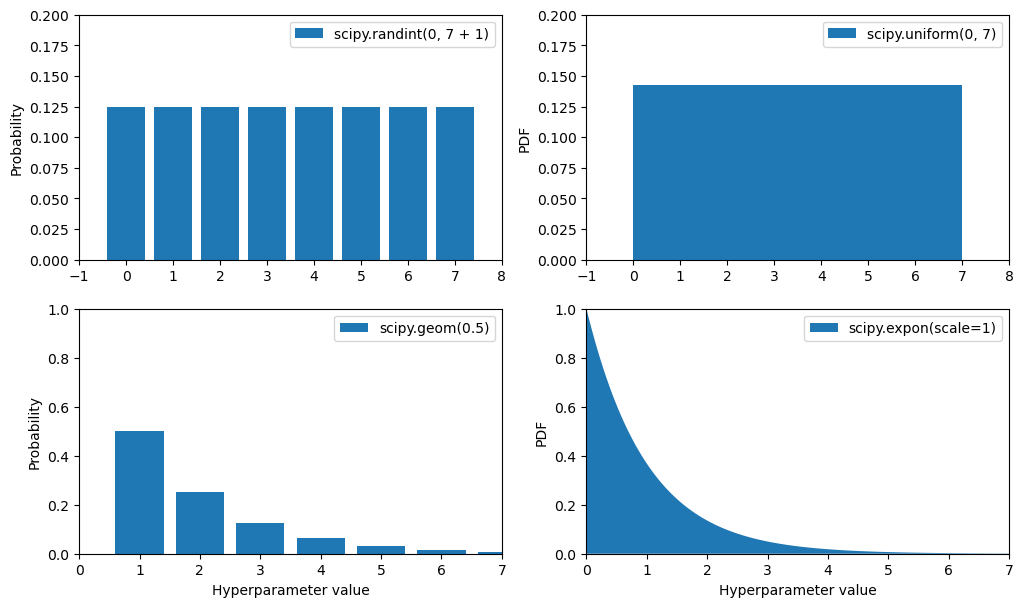

In [134]:
# extra code – plots a few distributions you can use in randomized search

from scipy.stats import randint, uniform, geom, expon

xs1 = np.arange(0, 7 + 1)
randint_distrib = randint(0, 7 + 1).pmf(xs1)

xs2 = np.linspace(0, 7, 500)
uniform_distrib = uniform(0, 7).pdf(xs2)

xs3 = np.arange(0, 7 + 1)
geom_distrib = geom(0.5).pmf(xs3)

xs4 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs4)

plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.bar(xs1, randint_distrib, label="scipy.randint(0, 7 + 1)")
plt.ylabel("Probability")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 2)
plt.fill_between(xs2, uniform_distrib, label="scipy.uniform(0, 7)")
plt.ylabel("PDF")
plt.legend()
plt.axis([-1, 8, 0, 0.2])

plt.subplot(2, 2, 3)
plt.bar(xs3, geom_distrib, label="scipy.geom(0.5)")
plt.xlabel("Hyperparameter value")
plt.ylabel("Probability")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 4)
plt.fill_between(xs4, expon_distrib, label="scipy.expon(scale=1)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.show()

Here are the PDF for `expon()` and `loguniform()` (left column), as well as the PDF of log(X) (right column). The right column shows the distribution of hyperparameter _scales_. You can see that `expon()` favors hyperparameters with roughly the desired scale, with a longer tail towards the smaller scales. But `loguniform()` does not favor any scale, they are all equally likely:

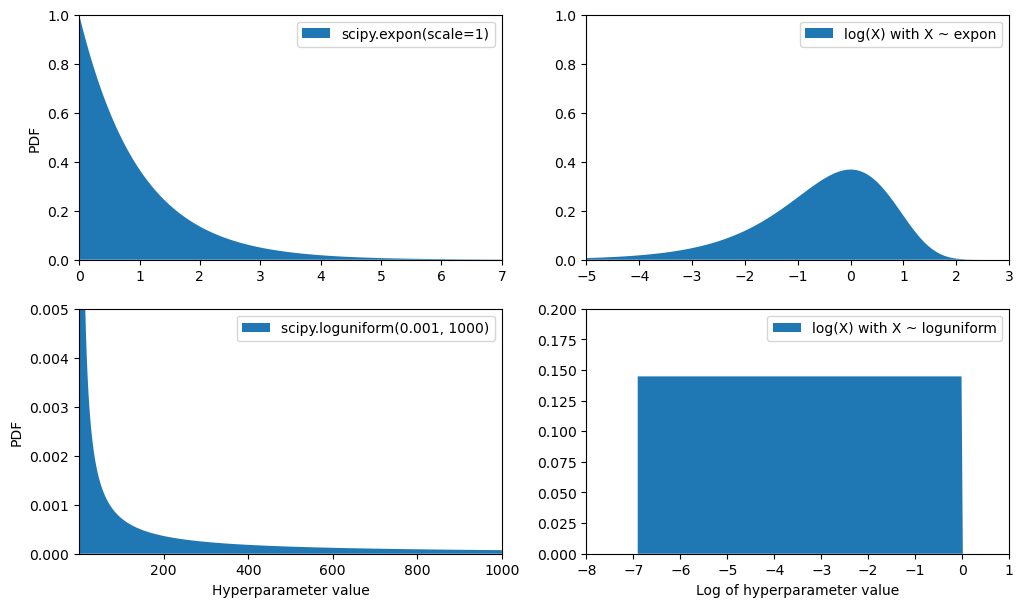

In [135]:
# extra code – shows the difference between expon and loguniform

from scipy.stats import loguniform

xs1 = np.linspace(0, 7, 500)
expon_distrib = expon(scale=1).pdf(xs1)

log_xs2 = np.linspace(-5, 3, 500)
log_expon_distrib = np.exp(log_xs2 - np.exp(log_xs2))

xs3 = np.linspace(0.001, 1000, 500)
loguniform_distrib = loguniform(0.001, 1000).pdf(xs3)

log_xs4 = np.linspace(np.log(0.001), np.log(1000), 500)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(log_xs4)

plt.figure(figsize = (12, 7))

plt.subplot(2, 2, 1)
plt.fill_between(xs1, expon_distrib,
                 label="scipy.expon(scale=1)")
plt.ylabel("PDF")
plt.legend()
plt.axis([0, 7, 0, 1])

plt.subplot(2, 2, 2)
plt.fill_between(log_xs2, log_expon_distrib,
                 label="log(X) with X ~ expon")
plt.legend()
plt.axis([-5, 3, 0, 1])

plt.subplot(2, 2, 3)
plt.fill_between(xs3, loguniform_distrib,
                 label="scipy.loguniform(0.001, 1000)")
plt.xlabel("Hyperparameter value")
plt.ylabel("PDF")
plt.legend()
plt.axis([0.001, 1000, 0, 0.005])

plt.subplot(2, 2, 4)
plt.fill_between(log_xs4, log_loguniform_distrib,
                 label="log(X) with X ~ loguniform")
plt.xlabel("Log of hyperparameter value")
plt.legend()
plt.axis([-8, 1, 0, 0.2])

plt.show()

## Analazing the Best Model and Their Errors

In [136]:
final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.  , 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [137]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
    reverse = True
)

[(0.18836603202647126, 'log__median_income'),
 (0.07795960969938898, 'cat__ocean_proximity_INLAND'),
 (0.06110388595864347, 'bedrooms__ratio'),
 (0.05772194900488602, 'rooms_per_house__ratio'),
 (0.04569274355282605, 'people_per_house__ratio'),
 (0.041977095119231075, 'geo__Cluster 30 similarity'),
 (0.024893290428216707, 'geo__Cluster 9 similarity'),
 (0.02349145973584661, 'geo__Cluster 36 similarity'),
 (0.021384735075780065, 'geo__Cluster 18 similarity'),
 (0.019231937253583756, 'geo__Cluster 3 similarity'),
 (0.019114201150802552, 'geo__Cluster 32 similarity'),
 (0.01740110192655986, 'geo__Cluster 25 similarity'),
 (0.016281601452371793, 'geo__Cluster 1 similarity'),
 (0.015974756525084677, 'geo__Cluster 26 similarity'),
 (0.014014150061434243, 'geo__Cluster 7 similarity'),
 (0.013588284206905332, 'geo__Cluster 10 similarity'),
 (0.01344850861123562, 'geo__Cluster 12 similarity'),
 (0.013432151644106247, 'geo__Cluster 34 similarity'),
 (0.012971875049373518, 'geo__Cluster 19 simila

###  TIP - Extra Code

The `sklearn.feature_selection.SelectFromModel` transformer can automatically drop the least useful features for you: when you fit it, it trains a model (typically a random forest), looks at its feature_importances_ attribute, and selects the most useful features. Then when you call `transform()`, it drops the other features.


In [138]:
from sklearn.feature_selection import SelectFromModel

In [139]:
select_model = SelectFromModel(estimator = final_model['random_forest'], 
                               prefit = True
                            ) # prefit = True when the model was previously trained

In [140]:
housing_select_model = final_model['preprocessing'].transform(housing)

In [141]:
housing_preprocessing_columns = final_model['preprocessing'].get_feature_names_out()

In [142]:
housing_selected = select_model.transform(housing_select_model)

In [143]:
features_selected = [name for name, selected in zip(housing_preprocessing_columns, select_model.get_support()) if selected]
features_selected

['bedrooms__ratio',
 'rooms_per_house__ratio',
 'people_per_house__ratio',
 'log__median_income',
 'geo__Cluster 3 similarity',
 'geo__Cluster 9 similarity',
 'geo__Cluster 18 similarity',
 'geo__Cluster 25 similarity',
 'geo__Cluster 30 similarity',
 'geo__Cluster 32 similarity',
 'geo__Cluster 36 similarity',
 'cat__ocean_proximity_INLAND']

## Evaluate Your System on the Test Set

In [144]:
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [145]:
final_predictions = final_model.predict(X_test)

In [146]:
final_rmse = mean_squared_error(y_test, final_predictions, squared = False)
final_rmse

c:\Users\HP\miniconda3\envs\machine\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


41422.168800999665

In [148]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)
            )
        )

array([39272.70918656, 43465.46272048])

In [149]:
# extra code – shows how to compute a confidence interval for the RMSE
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(39272.70918655866, 43465.4627204751)

Alternatively, we could use a z-score rather than a t-score. Since the test set is not too small, it won't make a big difference:

In [150]:
# extra code – computes a confidence interval again using a z-score
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(39273.35682173406, 43464.87754854228)

## Launch, Monitor, and  Mantain Your System

In [153]:
import joblib

joblib.dump(final_model, "models/my_california_housing_model.pkl")

['models/my_california_housing_model.pkl']

In [155]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

final_model_reloaded = joblib.load("models/my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

# Try out! - Exercises